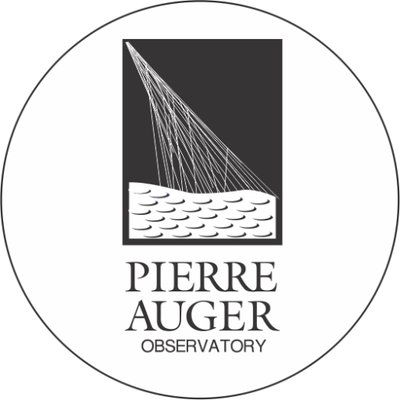
# Energy Calibration

<i>Notebook released together with the Pierre Auger Observatory Open Data release (<a href="https://doi.org/10.5281/zenodo.10488964">DOI 10.5281/zenodo.10488964</a>). More information at the <a href="https://www.auger.org/opendata/">Auger open data website</a>.</i>

The energy estimation for the vertical (zenith < 60 degrees) events recorded by the Pierre Auger Surface Detector (SD-1500 array) relies on the calibration of its energy estimator, the shower size S(1000), i.e. the signal at 1000 m from the shower impact at the ground, or shower core, in the plane of the shower front. To calibrate the shower size we profit from the measurement of the shower calorimetric energy performed by the Fluorescence Detector (FD) for a subsample of high quality events simultaneously recorded by both the SD and FD, the so-called golden hybrid events.

NOTE: this is a **simplified version** of the energy calibration applied to data from the Pierre Auger Observatory. For details on the full energy calibration procedure please refer to the following publications:

[1] Pierre Auger Collaboration [A. Aab et al.], "A measurement of the cosmic ray energy spectrum above 2.5$\cdot$10$^{18}$ eV using the Pierre Auger Observatory", Phys. Rev. D. 102 (2020) 062005. DOI: https://doi.org/10.1103/PhysRevD.102.062005 arXiv: https://arxiv.org/abs/2008.06486

[2] Pierre Auger Collaboration [A. Aab et al.], "Data-driven estimation of the invisible energy of cosmic ray showers with the Pierre Auger Observatory", Phys. Rev. D 100 (2019) 082003. DOI: https://doi.org/10.1103/PhysRevD.100.082003 arXiv: https://arxiv.org/abs/1901.08040

[3] Pierre Auger Collaboration [A. Aab et al.], "Impact of atmospheric effects on the energy reconstruction of air showers observed by the surface detectors of the Pierre Auger Observatory", JINST 12 (2017) P02006. DOI: https://doi.org/10.1088/1748-0221/12/02/P02006 arXiv: https://arxiv.org/abs/1702.02835 


[4] Pierre Auger Collaboration [P. Abreu et al.], "The effect of the geomagnetic field on cosmic ray energy estimates and large scale anisotropy searches on data from the Pierre Auger Observatory", J. Cosmol. Astropart. Phys. 11 (2011) 022. DOI: https://doi.org/10.1088/1475-7516/2011/11/022 arXiv: https://arxiv.org/abs/1111.7122



In [1]:
# Data analysis tools
import pandas as pd
import numpy as np
from numpy import radians as rad
import math 

# Fitting and Plotting
import scipy.stats
from scipy.stats import norm
from scipy.optimize import curve_fit 
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Default values for plots
#plt.rcParams["figure.figsize"] = [12, 9] # figure width and height
plt.rcParams["figure.figsize"] = [14, 9] # figure width and height
plt.rcParams["font.size"] = 20


In [3]:
# Jupyter/ IPython formatting
from IPython.display import Math, Latex, display

In [4]:
# Data loading, encapsulated to make it less installation and OS dependant
import os.path
from zipfile import ZipFile
def AugerLoad(fdir,file):
    """
    Loads a file from the auger open data release. Can be either in the local directory,
    in the parent directory or in the augeropendata directory.
    File is identified by it directory *fdir* and filename *file* and can be found in the directory
    or in a zip file.
    """
    for loc in [".","..","augeropendata"]:
        fname=os.path.join(loc,fdir,file)
        if os.path.isfile(fname):
            return open(fname)
        zname=os.path.join(loc,fdir+".zip")
        if os.path.isfile(zname):
            with ZipFile(zname) as myzip:
                return myzip.open(os.path.join(fdir,file))


## Calibration of the SD-1500 array with golden hybrid data

The so-called *golden hybrid* events are simultaneously observed and independently reconstructed by the Fluorescence Detector (FD) and the Surface Detector (SD). Data collected by the SD-1500 array are identified by the flag `sd1500` = 1. The total energy as measured with the FD, `fd_totalEnergy`, and the SD shower size estimator S$_{38}$, `sd_s38`, are given in the released dataset file. The identifying flag for this analysis is `fd_hdCalibEye` == 1

The hybrid events are selected to guarantee a precise estimation of the FD energies and to minimize primary mass dependent biases due to the field of view of the FD telescopes, see \[1\]. The selection criteria are summarized as follows:
- stability of data taking and atmospheric data;
- quality of the shower geometry and profile measurement;
- fiducial volume cuts.

The calibration is performed by selecting events with E_FD > 3 x $10^{18}$ eV to guarantee a nearly 100% trigger efficiency of the SD-1500 array. Note that for the definition of the p.d.f of the likelihood fit we use events with energy above E > 2.5 x $10^{18}$ eV.

In [5]:
file_path = r"C:\Users\DELL\Desktop\project\summary\summary\dataSummarySD1500.csv"
hd = pd.read_csv(file_path, encoding='unicode_escape')





Select events for this analysis:
- Has `fd_hdCalibEye` set
- Fluorescence detector energy (`fd_totalEnergy`) above $3\,\mathrm{EeV}$ for fit and plots
- Fluorescence detector energy (`fd_totalEnergy`) above $2.5\,\mathrm{EeV}$ for p.d.f definition

Also prepare a dataframe with unique events, i.e., with each `id` present only once. This dataframe gets indexed by event `id` to allow to merge with data like averages from multi-eye events.

In [6]:
## weighted average in multi-eye events to be done before the energy cut 
## the energy cut will be done later on weighted average
fd_calib = hd[(hd.fd_hdCalibEye == 1)].copy() # copy so we can add columns later

fd_grouped = fd_calib.groupby('id')
fd_unique = fd_calib.drop_duplicates('id').set_index('id')

n_events = len(fd_calib)
n_unique = len(fd_unique)

display(Latex(f'''Read {n_events} calibration events of which {n_unique} unique have an energy above $2.5~ \\times 10^{{18}}\\,\\mathrm{{eV}}$.
    The total number of FD events (counting multi-eye events as multiple events) is {n_events}.'''))

<IPython.core.display.Latex object>

### Energy from the calorimetric FD measurement 


Get total energy of the event `fd_dtotalEnergy` and its uncertainty `fd_dtotalEnergy`. For multi-eye events, which are those where the `id` is repeated, we calculate the average of total energy weighted with the inverse of the squared uncertainty.

**Note**: in [1] the weighted average is made on the calorimetric energy and secondly the invisible energy correction [2] is applied to get the total FD energy and its uncertainty.


In [7]:
## Calculate weights: 1/uncertainty^2
fd_calib['fd_e_weight'] = 1 / np.square(fd_calib.fd_dtotalEnergy)

## Calculate E/sigma^2 
fd_calib['fd_e_weighted'] = fd_calib.fd_totalEnergy * fd_calib.fd_e_weight

## Calculated weighted energy average for multi-eye events
## and convert from series to 
weighted_sum = fd_grouped['fd_e_weighted'].sum()
sum_of_weights = fd_grouped['fd_e_weight'].sum()

# energy values in EeV
fd_e_avg = weighted_sum / sum_of_weights
fd_unique['fd_AVG'] = fd_e_avg

fd_e_avg_err = 1 / np.sqrt(sum_of_weights)
fd_unique['fd_ERR'] = fd_e_avg_err

In [8]:
## shower to shower fluctuations
## The contribution from shower-to-shower fluctuations to the uncertainty in E$_{SD}$ can be parameterized as
## a relative error in S$_{38}$.

def sh_to_sh (lgefd):
    """parameterization of the shower to shower fluctuations"""
    s2s = [0.127, -0.081, 0.0277]     
    return s2s[0] + s2s[1]*(lgefd - 18.5) + s2s[2]*np.square(lgefd - 18.5)


In [9]:
##  vectors for p.d.f. (E > 2.5 EeV)
sd_s38_err = fd_unique.sd_ds1000 * fd_unique.sd_s38 / fd_unique.sd_s1000
sd_s38_err_sh = np.sqrt(np.square(sd_s38_err) + np.square(sh_to_sh(np.log10(fd_e_avg*1e18)) * fd_unique.sd_s38))

## vectors for the S38 E_FD correlation fit and plot (E > 3 EeV)
fd_calib_fit = fd_unique[fd_unique.fd_AVG > 3]

# energy values in eV
fd_e_fit = fd_calib_fit.fd_AVG * 1e18
fd_e_err_fit = fd_calib_fit.fd_ERR * 1e18
sd_e_fit = fd_calib_fit.sd_energy * 1e18
sd_s38_fit= fd_calib_fit.sd_s38
sd_s38_err_fit = fd_calib_fit.sd_ds1000 * fd_calib_fit.sd_s38 / fd_calib_fit.sd_s1000
sd_s38_err_sh_fit = np.sqrt( np.square(sd_s38_err_fit) + np.square(sh_to_sh(np.log10(fd_e_fit)) * sd_s38_fit) )

display(Latex(f'''We get {len(fd_e_fit)} unique events with FD total energy above $3~ \\times 10^{{18}}\\,\\mathrm{{eV}}$.'''))

<IPython.core.display.Latex object>

### From S(1000) to S$_{38}$

The energy estimator for the Surface Detector is the shower size, S(1000), (`sd_s1000`), the signal at 1000 m from the shower impact point in the plane of the shower front. It is measured in units of vertical muon equivalent (VEM), corresponding to the signal released by a muon traversing the SD station vertically. Corrections of order 2% and 1% for the atmospheric and geomagnetic effects (`sd_wcorr`, `sd_gcorr`), respectively, are made to S(1000), see [3], [4]. For a given energy, the value of S(1000) decreases with the zenith angle because of the increasing atmospheric depth crossed by the shower. The corrected shower-size estimator, S$_{38}$, (`sd_s38`), is then derived by applying a zenith and energy dependent factor, parameterized with a third degree polynomial in terms of the variable x = cos$^2 \theta$ - cos$^2 38^\circ$. It can be seen as the signal that a shower would have produced had it arrived at 38$^\circ$, the median angle of the zenith distribution. For more details see [1] and references therein. 

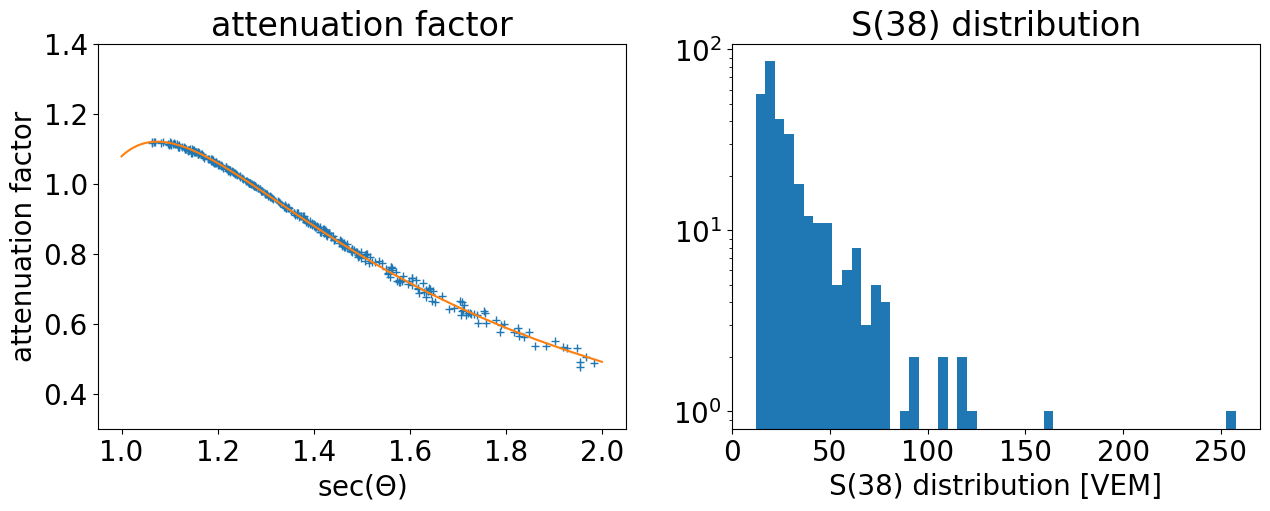

In [10]:
# CONSTANT CIC CURVE PLOT PRD @ 25 VEM INTENSITY THRESHOLD ( ~ 5 x 10^18 eV)
ap25 = [0.924103, -1.54603, -0.914497]

def cic (zen, apars):
    cc = np.square(np.cos(rad(zen))) - 0.621
    return ((apars[2]*cc + apars[1])*cc + apars[0])*cc + 1  # Honer evaluation

thetas = np.linspace(0, 60)
cic_th = cic(thetas, ap25)


## SD zenith
szen = fd_calib_fit.sd_theta

## S(1000) with weather and geomagnetic corrections / S_38

cicfacwg = (fd_calib_fit.sd_s1000 * fd_calib_fit.sd_wcorr * fd_calib_fit.sd_gcorr / sd_s38_fit)

plt.figure(figsize=(15, 5)) 

plt.subplot(121)
plt.plot(1 / np.cos(rad(szen)), cicfacwg, '+')
plt.plot(1 / np.cos(rad(thetas)), cic_th)

plt.xlabel(r'sec($\Theta$)')
plt.title('attenuation factor')
plt.ylabel('attenuation factor')
#
plt.ylim(0.3, 1.4)
#plt.xlim(1, 2)    

plt.subplot(122)
plt.hist(sd_s38_fit, bins=50)

#plt.xlabel('cos$^2$($\Theta$)')
plt.title('S(38) distribution')
plt.xlabel('S(38) distribution [VEM]')
plt.yscale('log')


### Correlation plot 

The correlation between FD energies and S$_{38}$ is well described by a power law relationship E$_{FD}$ = A S$_{38}\,^{B}$. The two parameters A and B are fitted to the selected hybrid data. For the fit we use a tailored maximum-likelihood method where the probability density function is given by a bootstrap estimate of the energy distribution of the selected events and where the uncertainties in S$_{38} and FD energy are evaluated on an event-by-event basis. The calibration constants A and B are used to estimate the energy for the bulk of SD events and they define the SD energy scale. For details see [1] and in particular Appendix B.

In [11]:
## SIMPLE FIT WITH POWER LAW FUNCTION
# FCN DEFINITION E_SD = A*S_38^B

def power(x, a, b):
     """pw"""
     return (a * pow(x, b))

def poweri(x, a, b):
     """pwi"""
     return (pow(x*a, b))

vals, covar = curve_fit(power, sd_s38_fit, fd_e_fit/1e18, p0=(0.1, 1))
vals1, covar1 = curve_fit(poweri, fd_e_fit/1e18, sd_s38_fit, p0=(1 / vals[0], 1 / vals[1]))

np.set_printoptions(precision=4)

display(Latex(f''' SIMPLE FIT PARAMETERS: $~$ A = ({vals[0]:.4f} $\\pm$ {np.sqrt(covar[0,0]):.1}) 
$\\times ~ 10^{{18}}$ eV, 
B = {vals[1]:.3f} $\\pm$ {np.sqrt(covar[1,1]):.1}'''))


<IPython.core.display.Latex object>

In [12]:
## LOGLIKELIHOOD FIT IMPLEMENTATION

def bootstrap_pdf(fe, fs, fpar):
    """ Probability density function 
    for the detection of a hybrid shower  
    Note: sum runs on data sample E > 2.5
    
    Args: 
        FD energy in EeV, s38, fit parameters    
    Returns:
        probability density function     
    """ 
    

    # create column vectors of energies and signals to evaluate PDFs at
    efd = np.asarray(fe)[:, np.newaxis]
    s = np.asarray(fs)[:, np.newaxis]


    efd_exp = fd_e_avg #in EeV
    sigma_efd = fd_e_avg_err #in EeV
    
    s_exp = pow(efd_exp/fpar[0], 1/fpar[1])   
    sh2sh = sh_to_sh(np.log10(efd_exp * 1e18)) # E in eV
    sigma_s = np.sqrt( np.square(sd_s38_err) + np.square(sh2sh*s_exp) )

    ## sum on i events E_FD > 2.5 EeV
    pdf = np.sum(norm.pdf(efd, efd_exp, sigma_efd) * norm.pdf(s, s_exp, sigma_s), axis=1)      
 
    return (pdf / len(fd_e_avg))  
    
def loglike(parll):
    """unbinned likelihood function 
    Note: sum runs on data sample E > 3 EeV
    
    Args: 
        fit parameters    
    Returns:
        negative log-likelihood  
    """     
    log_lik = 0         
    ## sum on k events E_FD > 3 EeV 
    log_lik = - np.log(bootstrap_pdf(fd_e_fit / 1e18, sd_s38_fit, parll)).sum()
        
    # negative log-likelihood
    return log_lik

ipars = [vals[0], vals[1]]
#ipars = [0.19, 1]

result = minimize(loglike, ipars, method='Nelder-Mead')

print (result)

display(Latex(f''' LIKELIHOOD FIT PARAMETERS: $~$ A = {result.x[0]*10:.4f} 
$\\times ~ 10^{{17}}$ eV, 
B = {result.x[1]:.4f}'''))


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1631.6699853918021
             x: [ 1.854e-01  1.031e+00]
           nit: 27
          nfev: 51
 final_simplex: (array([[ 1.854e-01,  1.031e+00],
                       [ 1.854e-01,  1.031e+00],
                       [ 1.853e-01,  1.031e+00]]), array([ 1.632e+03,  1.632e+03,  1.632e+03]))


<IPython.core.display.Latex object>

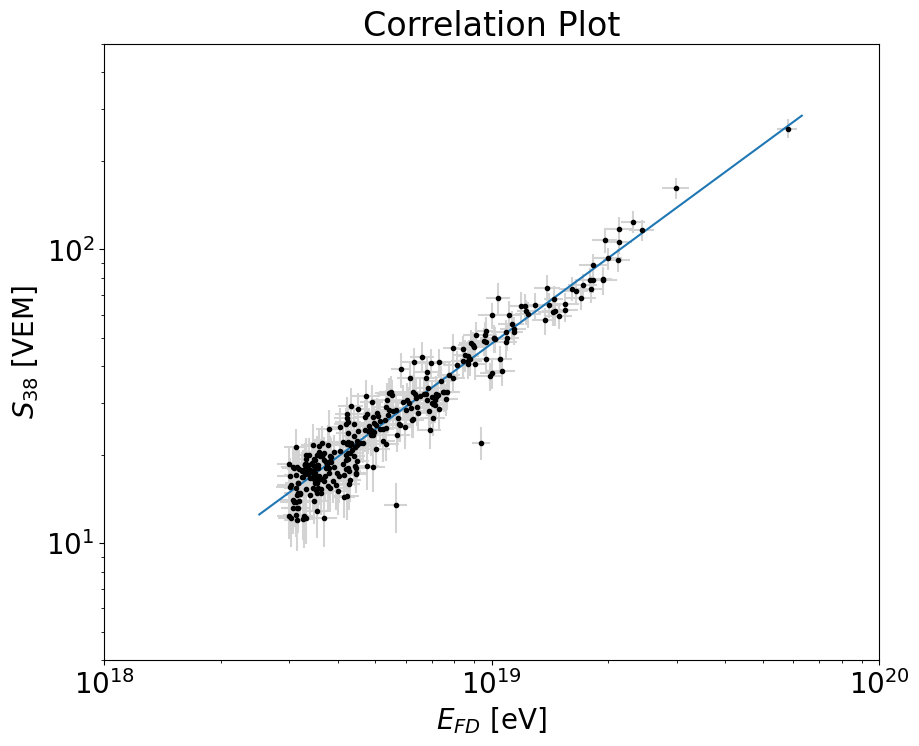

In [13]:
# PLOT DATA WITH POWER LAW FIT

x = 10**np.linspace(18.4, 19.8) # equal steps in log space

plt.figure(figsize=(10, 8)) 

plt.errorbar(fd_e_fit, sd_s38_fit, sd_s38_err_sh_fit, fd_e_err_fit, fmt='.k', ecolor='lightgray')

## SIMPLE FIT
#fit1 = pow(x / (vals[0] * 1e18), 1 / vals[1])
#plt.plot(x,fit1)

## LIKELIHOOD FIT
fit1 = pow(x / (result.x[0] * 1e18), 1 / result.x[1])
plt.plot(x, fit1)

plt.title('Correlation Plot')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$E_{FD}$ [eV]')
plt.ylabel('$S_{38}$ [VEM]')
plt.xlim(1e18, 1e20)
plt.ylim(4, 5e2)
None

## Distribution of E$_{SD}$/E$_{FD}$ and SD energy resolution 

The SD resolution $\sigma_{SD}$(E)/E can be inferred from data by analyzing in each energy bins the histograms of the ratio E$_{SD}$/E$_{FD}$, following a Gaussian ratio distribution. The resolution is $\sim$ 20% at 2$ \cdot$ 10$^{18}$ eV and tends smoothly to $\sim $ 7% above 2$\cdot$10$^{19}$ eV. The FD energy resolution $\sigma_{FD}$(E)/E is ~ 7.4%, see [1]. The overall resolution is obtained by subtracting in quadrature the FD energy resolution from the $\sigma$ of the fitted Gaussian.

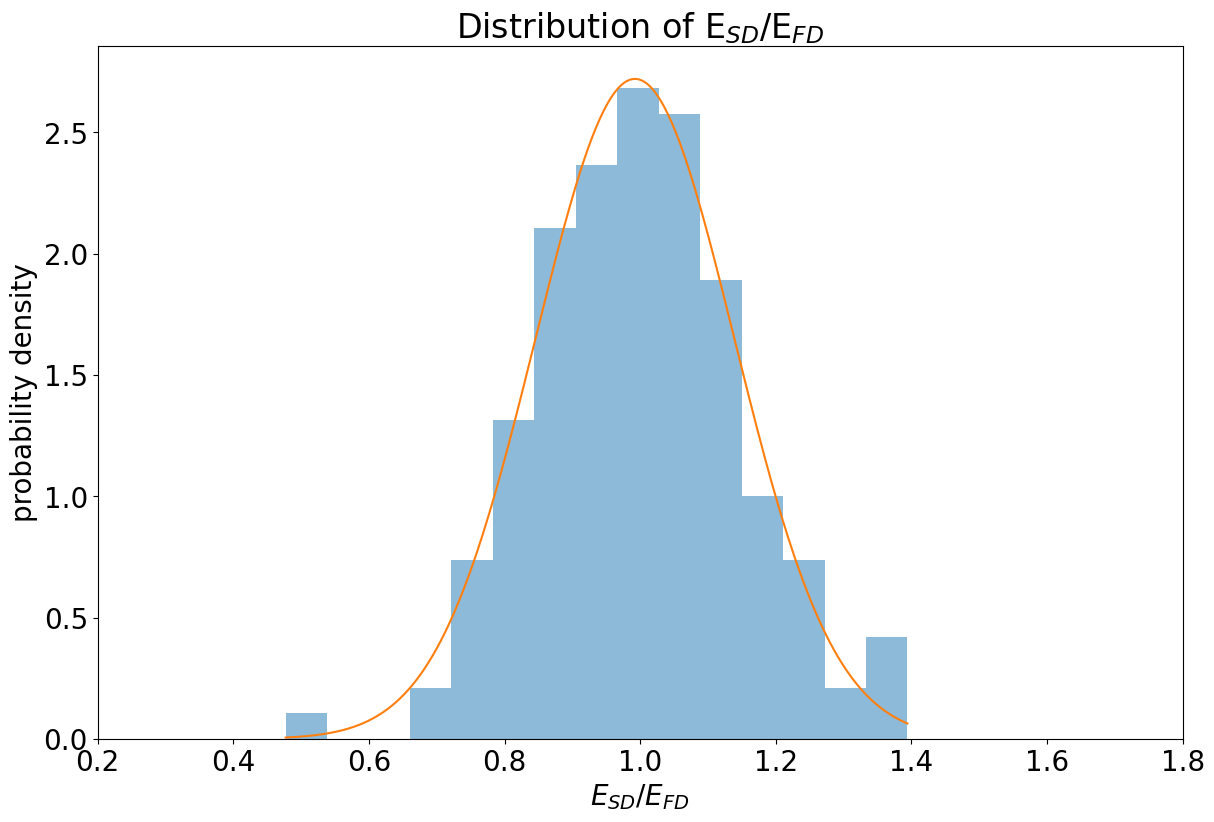

<IPython.core.display.Latex object>

In [14]:
# DISTRIBUTION OF E_SD/E_FD + GAUSSIAN FIT

##  FULL SAMPLE
fig, ax = plt.subplots(1,1)

datat = sd_e_fit / fd_e_fit

n, binst, patches = ax.hist(datat,15, density=1, alpha=0.5)

binw = binst[1] - binst[0]

centers = (0.5*(binst[1:] + binst[:-1]))

x = np.linspace(min(datat), max(datat), 310)

pars, cov = curve_fit(lambda x, mu, sig : norm.pdf(x, mu, sig), centers, n, p0=[1, 0.15])  
                                                                                                                                                  
ax.set_title('Distribution of E$_{SD}$/E$_{FD}$')

##plot the fit function
plt.plot(x, norm.pdf(x, *pars))

plt.xlabel('$E_{SD}/E_{FD}$')
plt.ylabel('probability density')
plt.xlim(0.2,1.8)
plt.show()

reso = np.sqrt(np.square(pars[1]) - np.square(0.074)) * 100

display(Latex(f'''RMS DEVIATION  
$\\mu$ = {pars[0]:.2f} $\\pm$ {np.sqrt(cov[0,0]):.2f}, $\\sigma$ = {pars[1]:.2f} $\\pm$ {np.sqrt(cov[1,1 ]):.3f} 
$~~~$ SD OVERALL RESOLUTION {reso:.0f} % '''))




## Calibration of SD-750 data

The same procedure is applied to data collected by the SD-750 array with energy above $10^{16.5}$ eV. Data are identified by the flag `sd750` = 1. The SD shower size estimator S$_{35}$, `sd_s35`, the signal at the optimum distance of 450 m, `sd_s450`, corrected for the atmospheric attenuation, is given in the released data file.

In [15]:
import pandas as pd

# Manually specify the file path
file_path = r"C:\Users\DELL\Desktop\project\summary\summary\dataSummarySD750.csv"

# Read the CSV
hdLE = pd.read_csv(file_path)


In [16]:
hdLE.columns

Index(['id', 'sdid', 'gpstime', 'sd750', 'multiEye', 'sd1500',
       'sd_gpsnanotime', 'sd_theta', 'sd_phi', 'sd_energy', 'sd_l', 'sd_b',
       'sd_ra', 'sd_dec', 'sd_x', 'sd_dx', 'sd_y', 'sd_dy', 'sd_z',
       'sd_easting', 'sd_northing', 'sd_altitude', 'sd_s450', 'sd_ds450',
       'sd_s35', 'sd_beta', 'sd_gamma', 'sd_chi2', 'sd_ndf', 'sd_geochi2',
       'sd_nbstat', 'fd_id', 'fd_gpsnanotime', 'fd_hdSpectrumEye',
       'fd_hdCalibEye', 'fd_hdXmaxEye', 'fd_theta', 'fd_dtheta', 'fd_phi',
       'fd_dphi', 'fd_l', 'fd_b', 'fd_ra', 'fd_dec', 'fd_totalEnergy',
       'fd_dtotalEnergy', 'fd_calEnergy', 'fd_dcalEnergy', 'fd_xmax',
       'fd_dxmax', 'fd_heightXmax', 'fd_distXmax', 'fd_dEdXmax', 'fd_ddEdXmax',
       'fd_x', 'fd_dx', 'fd_y', 'fd_dy', 'fd_z', 'fd_easting', 'fd_northing',
       'fd_altitude', 'fd_cherenkovFraction', 'fd_minViewAngle', 'fd_uspL',
       'fd_duspL', 'fd_uspR', 'fd_duspR', 'fd_hottestStationId',
       'fd_distSdpStation', 'fd_distAxisStation', 'sd_s38', 's

In [17]:

fd_calib_LE = hdLE[(hdLE.fd_hdCalibEye == 1)].copy() # copy so we can add columns later

fd_grouped_LE = fd_calib_LE.groupby('id')
fd_unique_LE = fd_calib_LE.drop_duplicates('id').set_index('id')

n_events_LE = len(fd_calib_LE)
n_unique_LE = len(fd_unique_LE)

display(Latex(f'''Read {n_events_LE} calibration events of which {n_unique_LE} unique.'''))



<IPython.core.display.Latex object>

In [18]:
## Calculate weights: 1/uncertainty^2
fd_calib_LE['fd_e_weight'] = 1 / np.square(fd_calib_LE.fd_dtotalEnergy)

## Calculate E/sigma^2 
fd_calib_LE['fd_e_weighted'] = fd_calib_LE.fd_totalEnergy * fd_calib_LE.fd_e_weight

## Calculated weighted energy average for multi-eye events
## and convert from series to 
weighted_sum_LE = fd_grouped_LE['fd_e_weighted'].sum()
sum_of_weights_LE = fd_grouped_LE['fd_e_weight'].sum()

# energy values in EeV
fd_e_avg_LE = weighted_sum_LE / sum_of_weights_LE
fd_unique_LE['fd_AVG'] = fd_e_avg_LE

fd_e_avg_err_LE = 1 / np.sqrt(sum_of_weights_LE)
fd_unique_LE['fd_ERR'] = fd_e_avg_err_LE


In [19]:
## shower to shower fluctuations 
## The contribution from shower-to-shower fluctuations to the uncertainty in E$_{SD}$ can be parameterized as
## a relative error in S$_{38}$.

def sh_to_sh_LE (lgefd):
    """parameterization of the shower to shower fluctuations for Low Energy data"""
    s2s = [0.104, -0.021, 0.01]    
    return s2s[0] + s2s[1]*(lgefd - 18.0) + s2s[2]*np.square(lgefd - 18.0)


In [20]:
##  vectors for p.d.f. (E > 10^16.5 EeV)

sd_s35_err = fd_unique_LE.sd_ds450 * fd_unique_LE.sd_s35 / fd_unique_LE.sd_s450
sd_s35_err_sh = np.sqrt(np.square(sd_s35_err) + np.square(sh_to_sh_LE(np.log10(fd_e_avg_LE*1e18)) * fd_unique_LE.sd_s35))



## vectors for the S38 E_FD correlation fit and plot (E > 10*17 eV)
fd_calib_fit_LE = fd_unique_LE[fd_unique_LE.fd_AVG > 0.1]

# energy values in eV
fd_e_fit_LE = fd_calib_fit_LE.fd_AVG * 1e18
fd_e_err_fit_LE = fd_calib_fit_LE.fd_ERR * 1e18

sd_e_fit_LE = fd_calib_fit_LE.sd_energy * 1e18
sd_s35_fit = fd_calib_fit_LE.sd_s35
sd_s35_err_fit = fd_calib_fit_LE.sd_ds450 * fd_calib_fit_LE.sd_s35 / fd_calib_fit_LE.sd_s450
sd_s35_err_sh_fit = np.sqrt( np.square(sd_s35_err_fit) + np.square(sh_to_sh_LE(np.log10(fd_e_fit_LE)) * sd_s35_fit))


display(Latex(f'''We get {len(fd_e_fit_LE)} unique events with FD total energy above $10^{{17}}\\,\\mathrm{{eV}}$.'''))

<IPython.core.display.Latex object>

### Correlation plot for S$_{35}$

The correlation between FD energies and S$_{35}$ is well described by a power law relationship E$_{FD}$ = A S$_{35}\,^{B}$. The parameters A and B are derived by appliying the same method to the selected hybrid data.

In [21]:
# deriving initial values with a simple powerlaw fit
valsLE, covarLE = curve_fit(power, sd_s35_fit, fd_e_fit_LE/1e18, p0=(0.01, 1))


np.set_printoptions(precision=4)

display(Latex(f''' SIMPLE FIT PARAMETERS: $~$ A = ({valsLE[0]:.4f} $\\pm$ {np.sqrt(covarLE[0,0]):.1}) 
$\\times ~ 10^{{18}}$ eV, 
B = {valsLE[1]:.3f} $\\pm$ {np.sqrt(covarLE[1,1]):.1}'''))


<IPython.core.display.Latex object>

In [22]:
## LOGLIKELIHOOD FIT IMPLEMENTATION

def bootstrap_pdf_LE(fe, fs, fpar):
    """ Probability density function 
    for the detection of a hybrid shower  
    Note: sum runs on data sample E > 10^16.5 eV
    
    Args: 
        FD energy in EeV, s35, fit parameters    
    Returns:
        probability density function     
    """ 
    

    # create column vectors of energies and signals to evaluate PDFs at
    efd = np.asarray(fe)[:, np.newaxis]
    s = np.asarray(fs)[:, np.newaxis]


    efd_exp = fd_e_avg_LE #in EeV
    sigma_efd = fd_e_avg_err_LE #in EeV
    
    s_exp = pow(efd_exp/fpar[0], 1/fpar[1])   
    sh2sh = sh_to_sh_LE(np.log10(efd_exp * 1e18)) # E in eV
    sigma_s = np.sqrt( np.square(sd_s35_err) + np.square(sh2sh*s_exp) )

    ## sum on i events E_FD > 10^16.5 eV
    pdf = np.sum(norm.pdf(efd, efd_exp, sigma_efd) * norm.pdf(s, s_exp, sigma_s), axis=1)      
 
    return (pdf / len(fd_e_avg_LE))  
    
def loglike(parll):
    """unbinned likelihood function 
    Note: sum runs on data sample E > 0.1 EeV
    
    Args: 
        fit parameters    
    Returns:
        negative log-likelihood  
    """     
    log_lik = 0         
    ## sum on k events E_FD > 0.1 EeV 
    log_lik = - np.log(bootstrap_pdf_LE(fd_e_fit_LE / 1e18, sd_s35_fit, parll)).sum()
        
    # negative log-likelihood
    return log_lik

iparsLE = [valsLE[0], valsLE[1]]
#ipars = [0.19, 1]

resultLE = minimize(loglike, iparsLE, method='Nelder-Mead')

print (resultLE)

display(Latex(f''' LIKELIHOOD FIT PARAMETERS: $~$ A = {resultLE.x[0]*10:.4f} 
$\\times ~ 10^{{17}}$ eV, 
B = {resultLE.x[1]:.4f}'''))

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 449.8653029771148
             x: [ 1.241e-02  1.021e+00]
           nit: 32
          nfev: 62
 final_simplex: (array([[ 1.241e-02,  1.021e+00],
                       [ 1.241e-02,  1.021e+00],
                       [ 1.242e-02,  1.021e+00]]), array([ 4.499e+02,  4.499e+02,  4.499e+02]))


<IPython.core.display.Latex object>

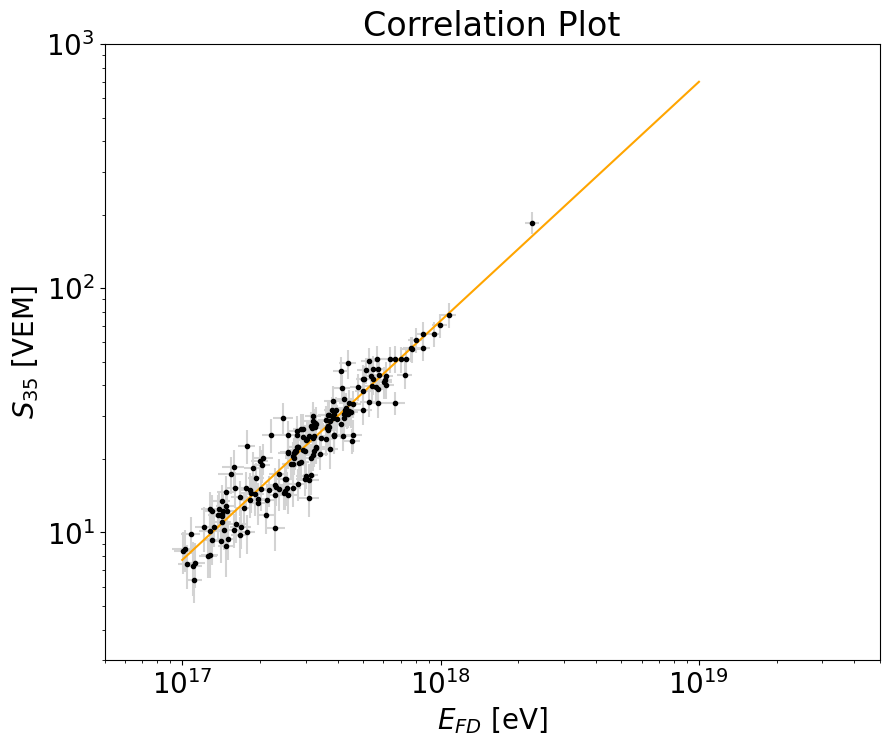

In [23]:
# PLOT DATA WITH POWER LAW FIT

x = 10**np.linspace(17.0, 19.0) # equal steps in log space

plt.figure(figsize=(10, 8)) 

plt.errorbar(fd_e_fit_LE, sd_s35_fit, sd_s35_err_sh_fit, fd_e_err_fit_LE, fmt='.k', ecolor='lightgray')

## SIMPLE FIT
#fit1 = pow(x / (vals[0] * 1e18), 1 / vals[1])
#plt.plot(x,fit1)

## LIKELIHOOD FIT
fit1 = pow(x / (resultLE.x[0] * 1e18), 1 / resultLE.x[1])
plt.plot(x, fit1, color='orange')

plt.title('Correlation Plot')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$E_{FD}$ [eV]')
plt.ylabel('$S_{35}$ [VEM]')
plt.xlim(5e16, 5e19)
plt.ylim(3, 1e3)
None

In [1]:
import qrcode

# URL of the Jupyter notebook
url = "http://localhost:8888/lab/tree/Desktop/project/notebook/notebook/energy-calibration.ipynb"

# Generate QR code
qr_code = qrcode.make(url)

# Save the QR code as an image
qr_code.save("notebook_qr.png")
